In [1]:
from bs4 import BeautifulSoup
import requests
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import date


### 1. Data exctraction

We use `BeautifulSoup` to scrape data from the MetaMates Talent Directory, hosted on Google Sheets and accessible through https://levels.fyi
<br><br> URL: https://docs.google.com/spreadsheets/d/1edAZoFG25lJpfSpTuJzD9hGijSzRfZ8v84H_Zak4gug

In [2]:
success = False  # flag to determine if the scrape was successful (sometimes only pulls ~100 records)
attempts = 0

while not success:
    # MetaMates Talent Directory (self-reported layoffs) can be accessed via https://levels.fyi
    url = "https://docs.google.com/spreadsheets/d/1edAZoFG25lJpfSpTuJzD9hGijSzRfZ8v84H_Zak4gug"
    html = requests.get(url).text
    soup = BeautifulSoup(html, "lxml")
    tables = soup.find_all("table")
    attempts += 1

    # ingest html string into pandas dataframe
    df = pd.read_html(str(tables[0]), skiprows=2, index_col=0)[0].reset_index(drop=True)

    if len(df) > 1000:
        success = True
        break
    if attempts == 10:  # exit loop, we probably need to fix something
        break

    print("Scrape unsuccessful. Trying again in 5 seconds.")
    time.sleep(
        5
    )  # quick cooldown to avoid possibly getting throttled from repeated requests

if success:
    print(f"Scrape successful after {attempts} attempt(s).")

    # save raw extract to disk, stamped with current date
    current_date_string = date.today().strftime("%m-%d-%Y")
    df.to_csv(
        Path(".")
        / "data"
        / "raw"
        / f"meta_talent_directory_extract_{current_date_string}.csv",
        index=False,
    )

    print(f"Shape of raw extract: {df.shape}")
else:
    print(f"10 consecutive scrapes were unsuccessful. Revision required.")


Scrape unsuccessful. Trying again in 5 seconds.
Scrape unsuccessful. Trying again in 5 seconds.
Scrape successful after 3 attempt(s).
Shape of raw extract: (2076, 14)


### 2. Data Cleaning

Since the data is self-reported and there is no data validation on entry, we need to apply some logic to better categorize reported department (work area).

High-level overview of procedure to categorize deparment:
1. Scan Job Title for "recruiter", "talent", "sourcer", "sourcing", etc. and assign these to "Recruiting"
    - lots of recruiters put "Recruiting" as their department, but there are many other recruiters who listed the department they recruit for (e.g. Engineering), so we want to handle these cases correctly
2. Scan provided Department for various substring tokens (see below)
    - the ordering of the tokens we search for is very deliberate; "Product" and "Design" are both valid departments, so how do we handle someone who lists "Product Design" as their department?
        - "Design" is likely more descriptive, so we give it priority in the list of of tokens we look for (i.e. "Product Design" -> "Design")
3. Scan provided Job Title for various substring tokens
    - if we still havent resolved a department after looking at the provided Department, we do another run-through of the ordered token list, this time looking for matches in the provided Job Title

In [3]:
# simple dictionary to map columns to more compact names
col_renaming_map = {
    "Meta Job Title": "JobTitle",
    "Functional Area (e.g. product, engineering, sales, etc.)": "DepartmentRaw",
    "Location": "Location",
    "Visa Support?": "Visa",
    "Years of Experience": "YoE",
}

# drop any column if its not found in the renaming dict, then apply the mapping
# (this step also removes all PII [Personal Identifiable Information] from the dataset)
df = (
    df[[col for col in df if col in col_renaming_map]]
    .rename(columns=col_renaming_map)
    .dropna(how="all")
)

df.head()


,JobTitle,DepartmentRaw,Location,Visa,YoE
1,Research Scientist,(ML / non-ML) Software Engineering,San Francisco Bay Area,No,1-3
2,Agency Partner Manager,Account Management/Sales,"Austin, TX",No,4-6
3,General Ledger Accountant,Accounting,San Francisco Bay Area,No,4-6
4,Executive Administrative Partner,Admin,Miami,No,10+
5,Partner Solutions Manager,"Ads Partnerships, Product",Singapore,Yes,10+


In [4]:
# list of tuples that converts role/department tokens into cleaned department labels
# needs to be ordered to handle edge cases like "Product Design" (which we would want to map to Design)
#
# this list could be expanded, but I stopped once I got < 10% being assigned to Other
dept_cleaning_map = [
    ("engineer", "Engineering"),
    ("recruit", "Recruiting"),
    ("talent", "Recruiting"),
    ("analytics", "Data Science"),
    ("market", "Marketing"),
    ("design", "Design"),
    ("product", "Product"),
    ("sales", "Sales"),
    ("partnership", "Partnerships"),
    ("operations", "Operations"),
    ("hr", "HR"),
    ("human resources", "HR"),
    ("data science", "Data Science"),
    ("communication", "Communications"),
    ("comms", "Communications"),
    ("research", "Data Science"),
    ("developer", "Engineering"),
    ("technical sourcer", "Recruiting"),
    ("talent", "Recruiting"),
    ("infra", "Engineering"),
]


def get_clean_dept(row: pd.Series) -> str:
    """Given a row from the talent directory df, assigns a cleaned department label.

    Args:
        row (pd.Series): row from the MetaMates talent df

    Returns:
        str: cleaned department label
    """
    dept_orig = row["DepartmentRaw"]
    title = row["JobTitle"]
    try:
        dept_orig = dept_orig.lower()  # convert to lower case for string-finding
        title = title.lower()
    except:
        return "Other"  # if one of dept/title are missing (rare)

    # some recruiters list the deparment they recruit for as their department (instead of Recruiting)
    if any(title.find(x) >= 0 for x in ["recruit", "sourcer", "sourcing"]):
        return "Recruiting"

    # try searching for any of the matching tokens in the provided Deparment
    for token, cleaned in dept_cleaning_map:
        if dept_orig.find(token) >= 0:
            return cleaned

    # try searching for any of the matching tokens in the provided Job Title
    for token, cleaned in dept_cleaning_map:
        if title.find(token) >= 0:
            return cleaned

    # couldn't find a match
    return "Other"


df["DepartmentClean"] = df.apply(get_clean_dept, axis=1)

df.head(10)


,JobTitle,DepartmentRaw,Location,Visa,YoE,DepartmentClean
1,Research Scientist,(ML / non-ML) Software Engineering,San Francisco Bay Area,No,1-3,Engineering
2,Agency Partner Manager,Account Management/Sales,"Austin, TX",No,4-6,Sales
3,General Ledger Accountant,Accounting,San Francisco Bay Area,No,4-6,Other
4,Executive Administrative Partner,Admin,Miami,No,10+,Other
5,Partner Solutions Manager,"Ads Partnerships, Product",Singapore,Yes,10+,Product
6,Quantitative Researcher,"Ads Research (user control, trust&transparency...","Bay Area, CA",Yes,1-3,Data Science
7,Technical Sourcer,AI/ML Engineering,Singapore,Yes,7-10,Recruiting
8,Analytics Manager,Analytics,New York,No,7-10,Data Science
9,Senior Staff Quantitative UX Researcher,Analytics / UXR,"San Francisco, CA, USA",No,7-10,Data Science
10,Marketing Science Partner,"Analytics, Marketing measurement, Design Exper...",Singapore,No,1-3,Data Science


In [5]:
# save processed extract to disk, stamped with current date
current_date_string = date.today().strftime("%m-%d-%Y")
df.to_csv(
    Path(".")
    / "data"
    / "processed"
    / f"meta_talent_directory_cleaned_{current_date_string}.csv",
    index=False,
)


### 3. Data Visualization (EDA)

In [6]:
def create_dept_bar_plot() -> None:
    """Creates a bar plot showing layoffs by department, showing both count and relative percentage/"""

    current_date_string_full = date.today().strftime("%B %-d, %Y")

    # get order we want to show the bars (descending order, but with Other last)
    ordered_deps = list(df["DepartmentClean"].value_counts().index)
    ordered_deps.remove("Other")
    ordered_deps.append("Other")
    # get this to compute relative percentages
    total_layoffs = len(df)

    # process df for plotting
    df_to_plot = df.copy()
    df_to_plot["Count"] = 1
    df_to_plot = (
        df_to_plot[["DepartmentClean", "Count"]]
        .groupby("DepartmentClean")
        .sum()
        .reindex(ordered_deps)
        .reset_index()
    )

    # https://stackoverflow.com/a/60917129
    def colors_from_values(values, palette_name):
        # normalize the values to range [0, 1]
        normalized = (values - min(values)) / (max(values) - min(values))
        # convert to indices
        indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
        # use the indices to get the colors
        palette = sns.color_palette(palette_name, len(values))
        return np.array(palette).take(indices, axis=0)

    g = sns.barplot(
        data=df_to_plot,
        y="DepartmentClean",
        x="Count",
        palette=colors_from_values(df_to_plot["Count"], "Blues"),
    )
    g.set(
        xlim=(None, df_to_plot["Count"].max() * 1.2)
    )  # gives room for the annotations
    g.set_title(
        "Self-Reported Meta Layoffs by Department - November 2022",
        fontdict={"fontweight": "bold"},
    )
    g.set(ylabel="")
    g.set(xlabel="Number of Self-Reported Layoffs")

    # add % annotations
    for c in g.containers:
        labels = [f" {(value.get_width() / total_layoffs):.2%}" for value in c]
        g.bar_label(c, labels=labels, label_type="edge")

    plt.figtext(
        0.99,
        0.99,
        f"Data sourced on {current_date_string_full} from MetaMates Talent Directory on https://layoffs.fyi",
        horizontalalignment="right",
        fontsize=8,
    )
    plt.figtext(
        0.99,
        -0.05,
        f"Percentages denote % of total self-reported layoffs ({len(df)} at time of extract).",
        horizontalalignment="right",
        fontsize=8,
    )
    plt.savefig(
        Path(".") / "plots" / f"dept_barplot_{current_date_string}.png",
        bbox_inches="tight",
        dpi=200,
    )
    plt.show()


def create_yoe_heatmap():
    """Creates a heatmap showing layoffs by department and YoE (years of experience)."""

    current_date_string_full = date.today().strftime("%B %-d, %Y")

    # get order we want to show the rows (descending order, but with Other last)
    ordered_deps = list(df["DepartmentClean"].value_counts().index)
    ordered_deps.remove("Other")
    ordered_deps.append("Other")

    # process df for plotting
    table_to_plot = pd.crosstab(df["DepartmentClean"], df["YoE"]).reindex(ordered_deps)[
        ["1-3", "4-6", "7-10", "10+"]
    ]

    g = sns.heatmap(
        data=table_to_plot,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        linewidth=0.5,
        xticklabels=["1 to 3", "4 to 6", "7 to 10", "10+"],
    )
    g.set_title(
        "Self-Reported Meta Layoffs by Department and YoE - November 2022\n",
        fontdict={"fontweight": "bold"},
    )
    g.set_xticklabels(g.get_xticklabels(), fontdict={"fontweight": "bold"})
    g.set(ylabel="")
    g.set(xlabel="\nYears of Experience")

    plt.figtext(
        0.99,
        0.99,
        f"Data sourced on {current_date_string_full} from MetaMates Talent Directory on https://layoffs.fyi",
        horizontalalignment="right",
        fontsize=8,
    )
    plt.figtext(
        0.99,
        -0.08,
        f"Cell values represent number of self-reported layoffs.",
        horizontalalignment="right",
        fontsize=8,
    )
    plt.savefig(
        Path(".") / "plots" / f"dept_yoe_heatmap_{current_date_string}.png",
        bbox_inches="tight",
        dpi=200,
    )
    plt.show()


def create_visa_heatmap():
    """Creates a heatmap showing layoffs by department and visa status."""

    current_date_string_full = date.today().strftime("%B %-d, %Y")

    # get order we want to show the rows (descending order, but with Other last)
    ordered_deps = list(df["DepartmentClean"].value_counts().index)
    ordered_deps.remove("Other")
    ordered_deps.append("Other")

    # process df for plotting
    _df = df.copy()
    _df["_Visa"] = _df["Visa"].map(lambda x: "N" if pd.isnull(x) else x[0])
    _df = _df.loc[_df._Visa.isin(["Y", "N"]), :]
    _df["_Visa"] = np.where(_df._Visa == "Y", "Yes", "No")
    table_to_plot = pd.crosstab(_df["DepartmentClean"], _df["_Visa"]).reindex(
        ordered_deps
    )[["No", "Yes"]]

    g = sns.heatmap(
        data=table_to_plot, annot=True, fmt=".0f", cmap="Blues", linewidth=0.5
    )
    g.set_title(
        "Self-Reported Meta Layoffs by Department and Visa Status - November 2022\n",
        fontdict={"fontweight": "bold"},
    )
    g.set_xticklabels(g.get_xticklabels(), fontdict={"fontweight": "bold"})
    g.set(ylabel="")
    g.set(xlabel="\nRequiring Visa Support")

    plt.figtext(
        0.99,
        0.99,
        f"Data sourced on {current_date_string_full} from MetaMates Talent Directory on https://layoffs.fyi",
        horizontalalignment="right",
        fontsize=8,
    )
    plt.figtext(
        0.99,
        -0.08,
        f"Cell values represent number of self-reported layoffs.",
        horizontalalignment="right",
        fontsize=8,
    )
    plt.savefig(
        Path(".") / "plots" / f"dept_visa_heatmap_{current_date_string}.png",
        bbox_inches="tight",
        dpi=200,
    )
    plt.show()


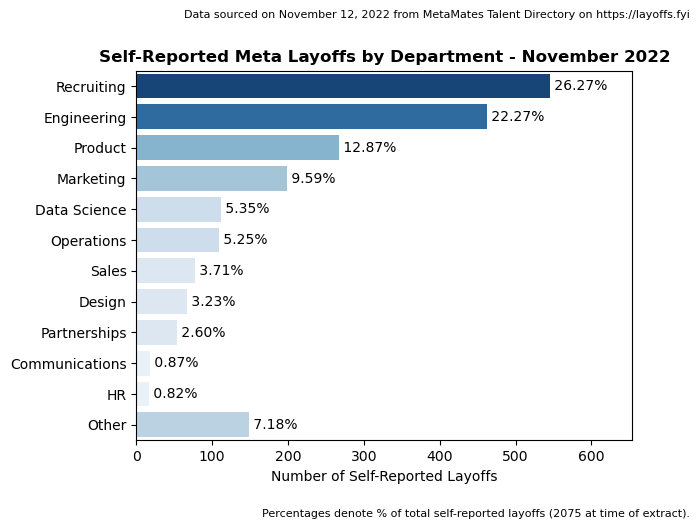

In [7]:
create_dept_bar_plot()


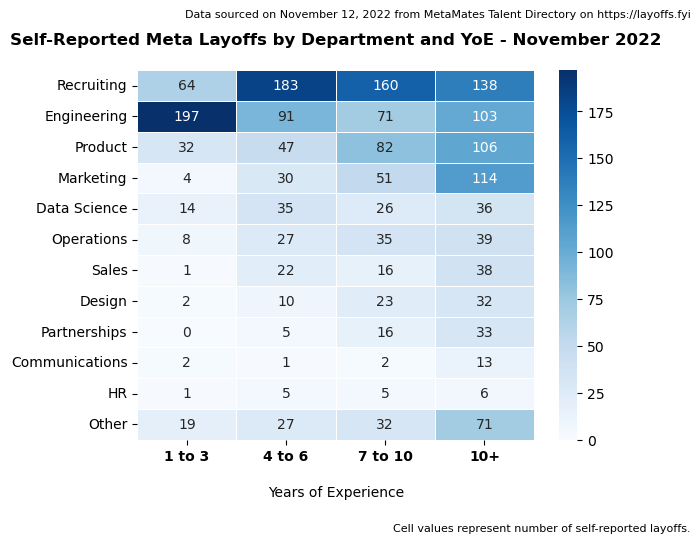

In [8]:
create_yoe_heatmap()


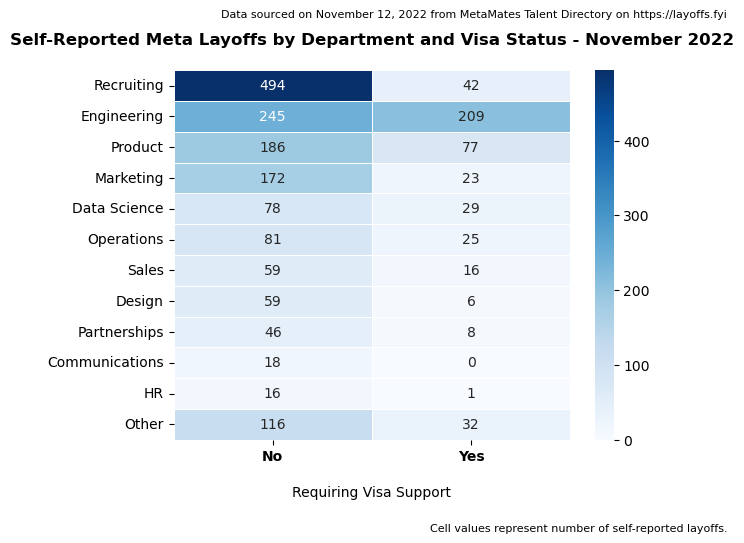

In [9]:
create_visa_heatmap()
